# **Boston Marathon project**

There is a lot of information on runners and their performance for Boston Marathon. Pick a year
(post-2012 has more info) and do some clustering. Specifically, use the tools at hand to
determine which clustering solution, including number of clusters and algorithm used, is best for
the marathon data. Once you have a solution you like, write a data story, including
visualizations, where you teach the reader something about the Boston Marathon based on your
clusters. Write up your report, including your process from start to finish. You must include
analysis as:
1. Using K-means and PCA, visualize the clusters for K = 2-10, include the Silhouette
scores
2. Draw bar graphs (both male & female in different color) for each cluster for male and
female, from the bar graphs, you can tell things as to which cluster contains the most number of
females (or male).
3. Draw bar graphs for runners in different ranges of age (dividing by 3 groups: 18-25,
26-40, 40-70 or so) for each cluster (in different colors), from the graph, you should be able to
answer which cluster contains the most young people, which cluster contains oldest people, etc.
4. Repeat 1-3 using GMM and T-SNE
5. Do the same things as above (1.-4.) for finishing time (which group runs fastest).

In [1]:

from google.colab import drive

drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt


In [3]:
csv_path = '/content/drive/My Drive/marathon_results_2016.csv'

df = pd.read_csv(csv_path)

cols = ["Age", "M/F", "Official Time"]
df = df[cols].dropna()

#   Convert gender to 0 / 1
df["Gender"] = (df["M/F"] == "M").astype(int)

#   Convert "HH:MM:SS" → seconds
df["Time_sec"] = pd.to_timedelta(df["Official Time"]).dt.total_seconds()

#   Age buckets for later bar-plots
age_bins   = [17, 25, 40, 70, np.inf]           # (18-25, 26-40, 41-70, 70+)
age_labels = ["18-25", "26-40", "41-70", "70+"]
df["Age_grp"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels)

display(df.head())

,Age,M/F,Official Time,Gender,Time_sec,Age_grp
0,21,M,2:12:45,1,7965.0,18-25
1,26,M,2:13:32,1,8012.0,26-40
2,31,M,2:14:02,1,8042.0,26-40
3,33,M,2:14:05,1,8045.0,26-40
4,23,M,2:15:45,1,8145.0,18-25


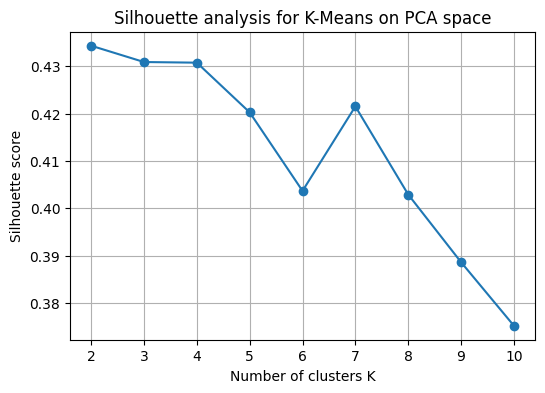

Best K by silhouette = 2


In [4]:
# ──────────────────────────────────────────────
# Prep X matrix (Gender, Age, Time_sec)
# ──────────────────────────────────────────────
X = df[["Age", "Gender", "Time_sec"]].copy()

#   Standardise (important before PCA / K-Means)
scaler = StandardScaler()
X_std  = scaler.fit_transform(X)

#   Reduce to 2 D for visualisation only
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

# ──────────────────────────────────────────────
# Storing silhouette scores
# ──────────────────────────────────────────────
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)

# ──────────────────────────────────────────────
# 1-C.  Plot silhouette vs K
# ──────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis for K-Means on PCA space")
plt.grid(True)
plt.show()

best_k = k_range[int(np.argmax(sil_scores))]
print(f"Best K by silhouette = {best_k}")


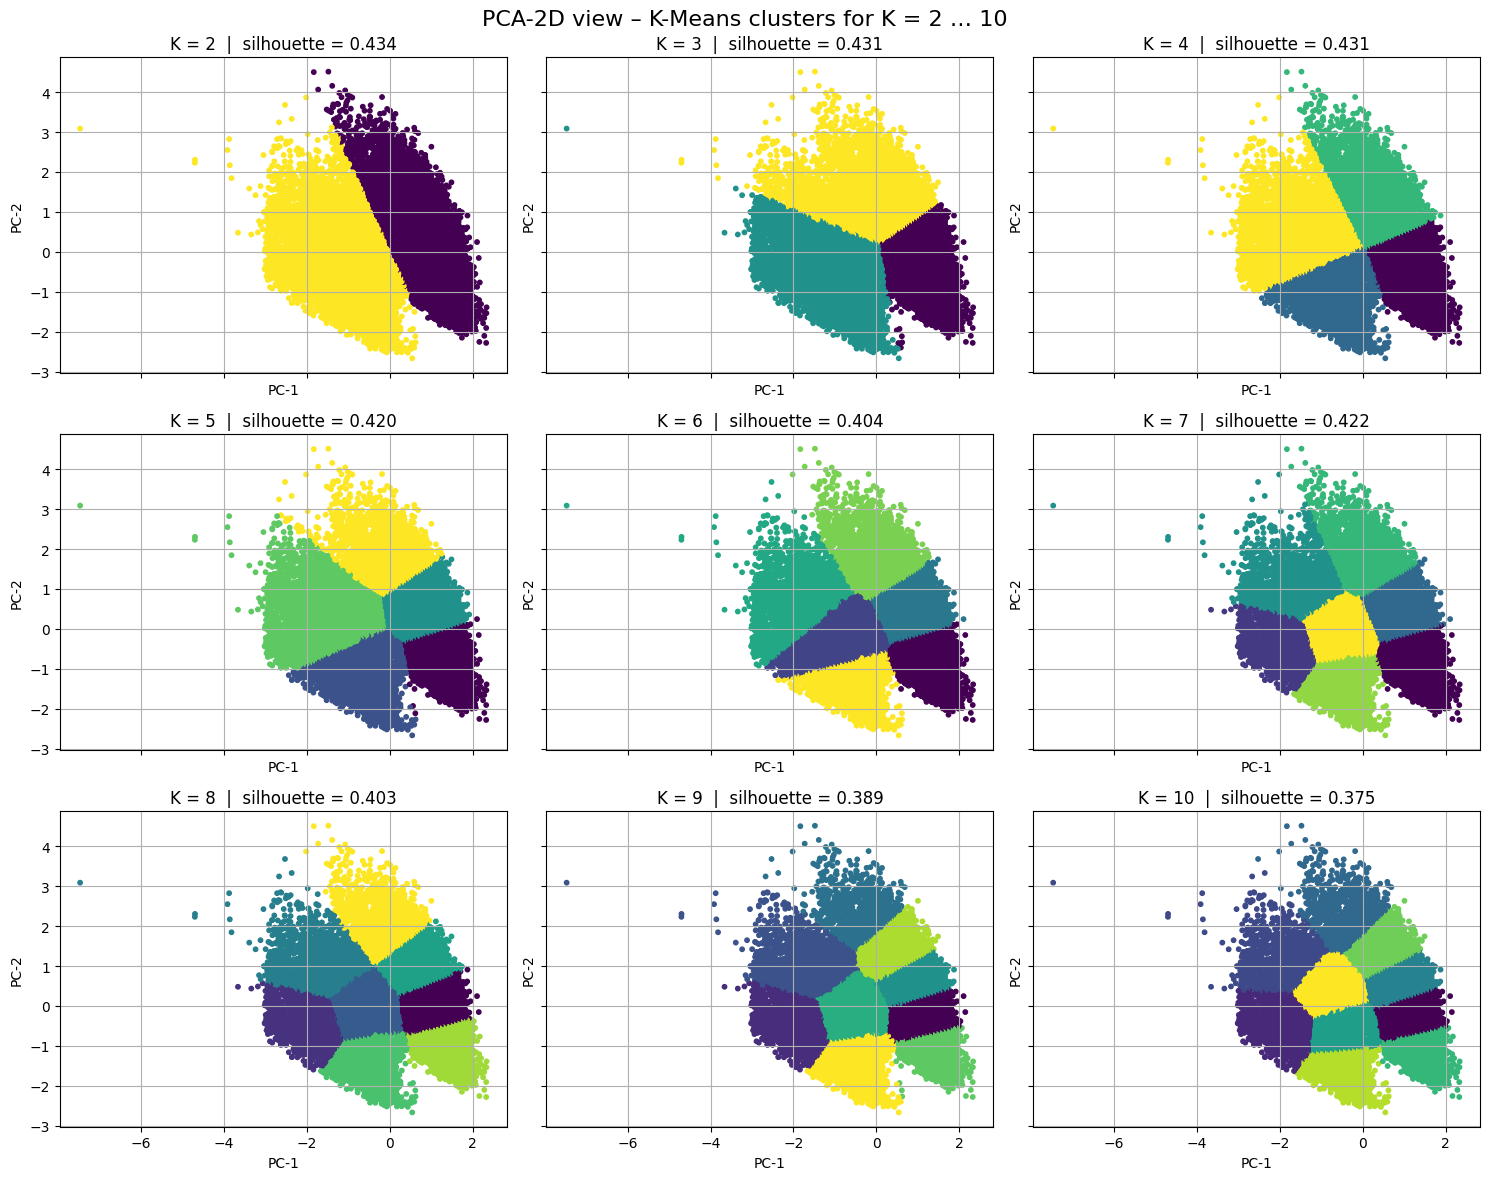


Silhouette scores


,K,Silhouette
0,2,0.434
1,3,0.431
2,4,0.431
3,5,0.420
4,6,0.404
5,7,0.422
6,8,0.403
7,9,0.389
8,10,0.375


In [5]:
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# ──────────────────────────────────────────────
# Parameters
# ──────────────────────────────────────────────
k_values = list(range(2, 11))          # 2 … 10
n_cols   = 3                           # 3 × 3 grid → 9 plots
n_rows   = math.ceil(len(k_values) / n_cols)

# ──────────────────────────────────────────────
# Prep the figure
# ──────────────────────────────────────────────
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5*n_cols, 4*n_rows),
    sharex=True, sharey=True
)

sil_scores = []                        # keep scores for printing

# ──────────────────────────────────────────────
# Loop over K values
# ──────────────────────────────────────────────
for ax, k in zip(axes.flatten(), k_values):
    km      = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels  = km.fit_predict(X_pca)
    sil     = silhouette_score(X_pca, labels)
    sil_scores.append((k, sil))

    # scatter
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10)
    ax.set_title(f"K = {k}  |  silhouette = {sil:.3f}")
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.grid(True)

# Hide any unused sub-axes (won’t happen here, but safe)
for ax in axes.flatten()[len(k_values):]:
    ax.axis("off")

fig.suptitle("PCA-2D view – K-Means clusters for K = 2 … 10", fontsize=16)
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────
# Print a neat table of silhouette scores
# ──────────────────────────────────────────────
score_df = pd.DataFrame(sil_scores, columns=["K", "Silhouette"])
print("\nSilhouette scores")
display(score_df.style.format({"Silhouette": "{:.3f}"}))


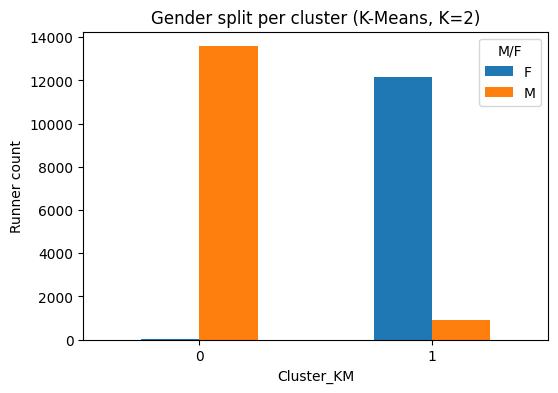

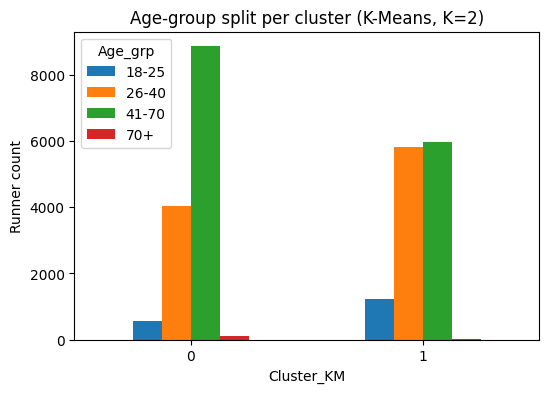

,Age,Time_sec
Cluster_KM,,
0,45.4,13214.6
1,39.6,15027.5


In [6]:

best_k = score_df.loc[score_df["Silhouette"].idxmax(), "K"]

#  Fit once more so df gets a single definitive label column
km_best = KMeans(n_clusters=int(best_k), random_state=42, n_init="auto")
df["Cluster_KM"] = km_best.fit_predict(X_pca)


gender_counts = pd.crosstab(df["Cluster_KM"], df["M/F"])
gender_counts.plot(
    kind="bar",
    figsize=(6,4),
    rot=0,
    ylabel="Runner count",
    title=f"Gender split per cluster (K-Means, K={best_k})"
)
plt.show()


age_counts = pd.crosstab(df["Cluster_KM"], df["Age_grp"])
age_counts.plot(
    kind="bar",
    figsize=(6,4),
    rot=0,
    ylabel="Runner count",
    title=f"Age-group split per cluster (K-Means, K={best_k})"
)
plt.show()

display(df.groupby("Cluster_KM")[["Age", "Time_sec"]].mean().round(1))


Average official finishing time per cluster
  • Cluster 0: 03:40:14  (13,215 s)
  • Cluster 1: 04:10:27  (15,028 s)


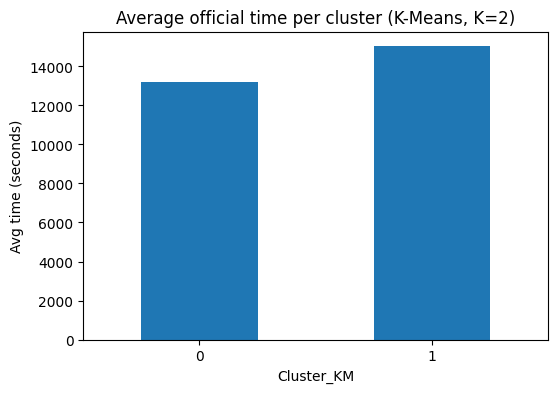

In [7]:
# ──────────────────────────────────────────────
#  Average finishing time per cluster
# ──────────────────────────────────────────────
avg_time_sec = (
    df.groupby("Cluster_KM")["Time_sec"]   # already in seconds
      .mean()
      .sort_values()                       # fastest cluster first
)

print("Average official finishing time per cluster")
for cid, sec in avg_time_sec.items():
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    print(f"  • Cluster {cid}: {h:02d}:{m:02d}:{s:02d}  ({sec:,.0f} s)")

# Optional: simple bar-plot
avg_time_sec.plot(kind="bar",
                  figsize=(6,4),
                  ylabel="Avg time (seconds)",
                  title=f"Average official time per cluster (K-Means, K={best_k})",
                  rot=0)
plt.show()


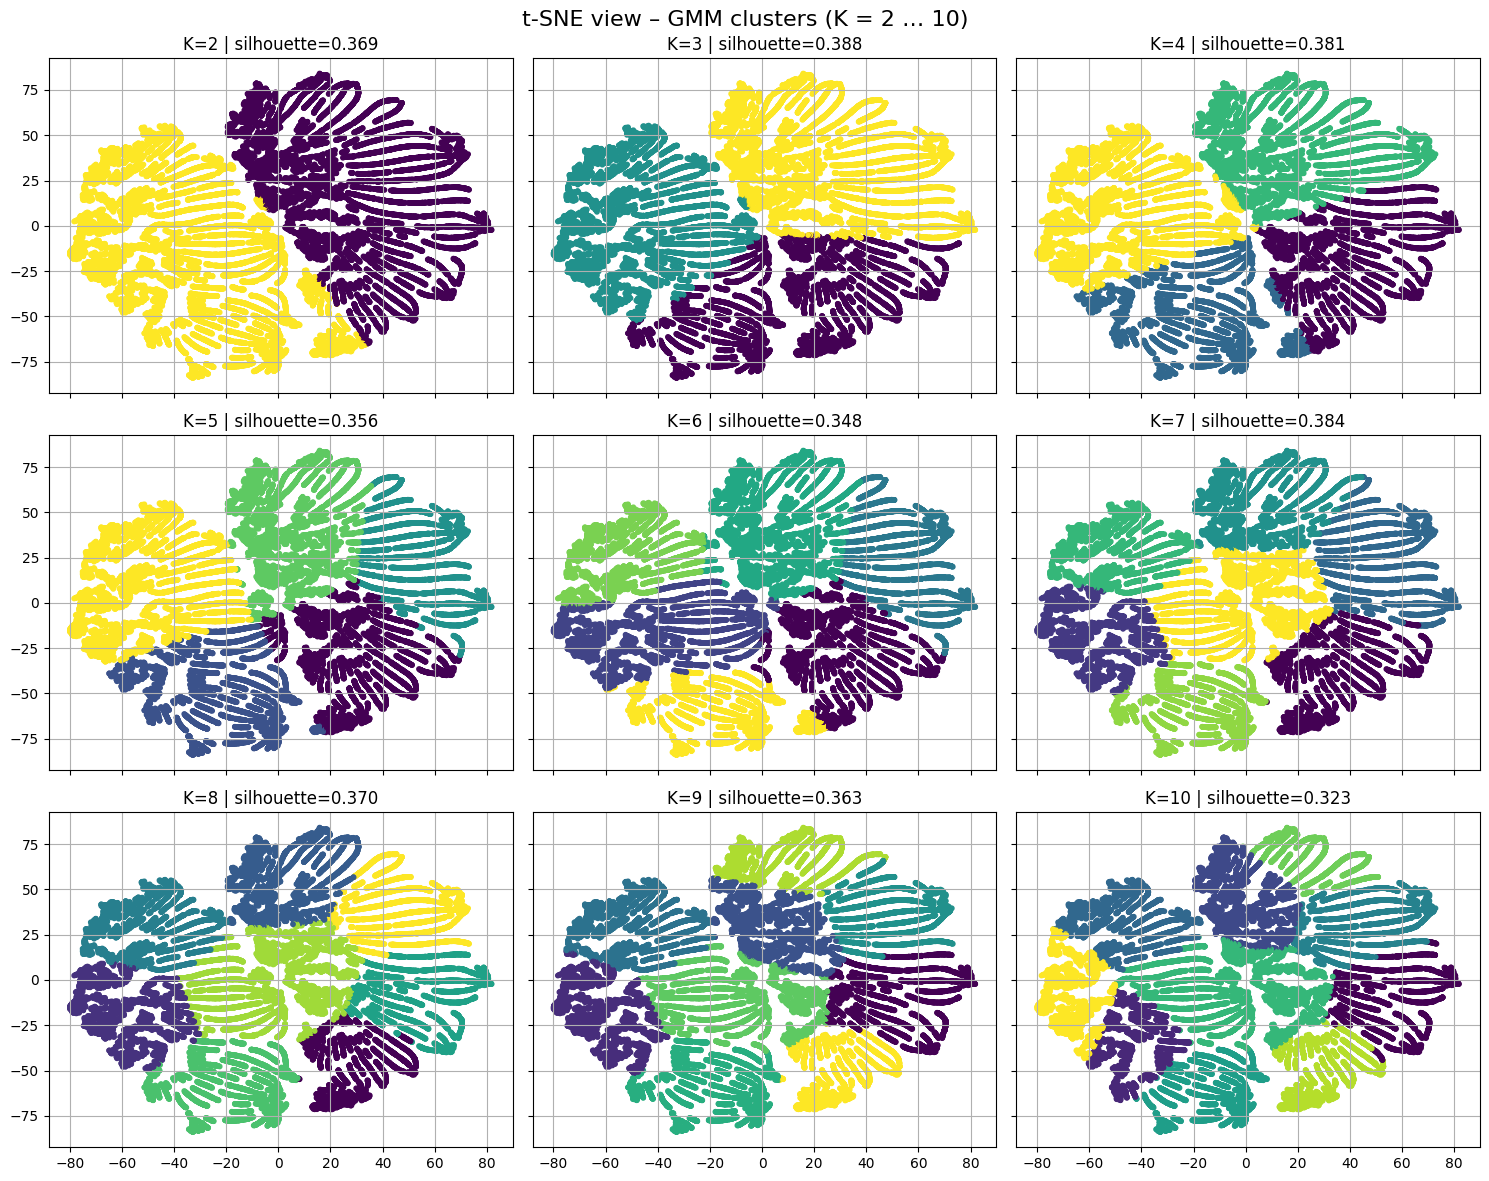

,K,Silhouette
0,2,0.369
1,3,0.388
2,4,0.381
3,5,0.356
4,6,0.348
5,7,0.384
6,8,0.370
7,9,0.363
8,10,0.323


In [8]:
from sklearn.manifold import TSNE
from sklearn.mixture  import GaussianMixture

# ──────────────────────────────────────────────
#  t-SNE embedding of the standardised data
# ──────────────────────────────────────────────
tsne = TSNE(
    n_components=2,
    perplexity   =50,
    learning_rate=200,
    random_state =42,
    init="pca",
)
X_tsne = tsne.fit_transform(X_std)

# ──────────────────────────────────────────────
#  Looping over K, score & plot (grid)
# ──────────────────────────────────────────────
import math
k_vals   = list(range(2,11))
n_cols   = 3
n_rows   = math.ceil(len(k_vals)/n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5*n_cols, 4*n_rows),
    sharex=True, sharey=True
)

gmm_scores = []

for ax, k in zip(axes.flatten(), k_vals):
    gmm    = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_tsne)
    sil    = silhouette_score(X_tsne, labels)
    gmm_scores.append((k, sil))

    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, s=10)
    ax.set_title(f"K={k} | silhouette={sil:.3f}")
    ax.grid(True)


for ax in axes.flatten()[len(k_vals):]:
    ax.axis("off")

fig.suptitle("t-SNE view – GMM clusters (K = 2 … 10)", fontsize=16)
plt.tight_layout()
plt.show()

# silhouette table
gmm_df = pd.DataFrame(gmm_scores, columns=["K","Silhouette"])
display(gmm_df.style.format({"Silhouette":"{:.3f}"}))


In [9]:
# ──────────────────────────────────────────────
# Feature matrix: just Time_sec
# ──────────────────────────────────────────────
X_time = df[["Time_sec"]].values
X_time_std = StandardScaler().fit_transform(X_time)

# ──────────────────────────────────────────────
#  Silhouette analysis for K = 2 … 11
# ──────────────────────────────────────────────
time_scores = []
for k in range(2,11):
    km   = KMeans(n_clusters=k, random_state=42, n_init="auto")
    lbl  = km.fit_predict(X_time_std)
    sil  = silhouette_score(X_time_std, lbl)
    time_scores.append((k,sil))

pd.DataFrame(time_scores, columns=["K","Silhouette"]).style.format({"Silhouette":"{:.3f}"})


,K,Silhouette
0,2,0.601
1,3,0.540
2,4,0.534
3,5,0.526
4,6,0.532
5,7,0.522
6,8,0.527
7,9,0.521
8,10,0.522


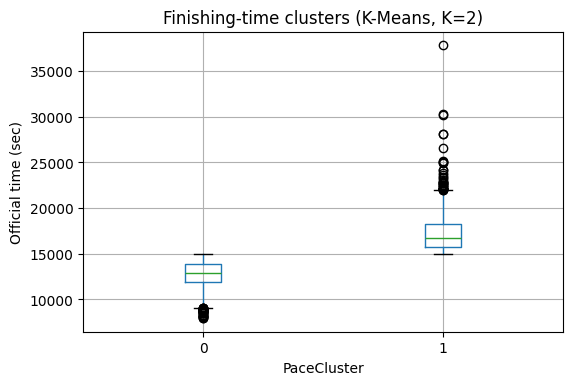

In [10]:
best_time_k = max(time_scores, key=lambda x: x[1])[0]
km_time     = KMeans(n_clusters=best_time_k, random_state=42, n_init="auto")
df["PaceCluster"] = km_time.fit_predict(X_time_std)

# Box-plot to see pace spread per cluster
df.boxplot(column="Time_sec", by="PaceCluster", figsize=(6,4))
plt.ylabel("Official time (sec)")
plt.title(f"Finishing-time clusters (K-Means, K={best_time_k})")
plt.suptitle("")
plt.show()


In [11]:
fast_gender = pd.crosstab(df["PaceCluster"], df["M/F"])
fast_gender

M/F,F,M
PaceCluster,,
0,7858,11059
1,4309,3404
